# Setup

### Import necessary modules and do some basic setup.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= '0.20'

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# TensorFlow ≥2.0 is required
import tensorflow_addons as tfa
import tensorflow_probability as tfp
import tensorflow as tf
assert tf.__version__ >= '2.0'

from tensorflow import keras
from tensorflow.keras import layers

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Common imports
import os
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import dask
import time
import math
import imageio
import PIL
dask.config.set({'array.slicing.split_large_chunks': False})

from IPython import display

# To make this notebook's output stable across runs
np.random.seed(42)

# Config matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Custom utils
from utils.utils_data import *
from utils.utils_ml import *
from utils.utils_plot import *

Num GPUs Available:  1


### Define some paths and constants.

In [2]:
# Paths
DATADIR = os.path.join(os.getcwd(), '..', 'data')

# Some constants
DATE_START = '1979-01-01'
DATE_END = '2020-12-31'
YY_TRAIN = [1979, 2015]
YY_TEST = [2016, 2020]

# Use normalization
DO_NORMALIZE = True

In [3]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

viridis_r = cm.get_cmap('viridis_r', 256)
newcolors = viridis_r(np.linspace(0, 1, 256))
pink = np.array([200/256, 200/256, 200/256, 1])
newcolors[:1, :] = pink
newcmp = ListedColormap(newcolors)

### Define some functions.

In [4]:
# Rescale image
def rescale_img(img_data, nan_mask=[], scaling=[]):
    img = np.copy(img_data)
    if DO_NORMALIZE:
        img *= scaling
    img[nan_mask] = np.nan
    img[img < 0.1] = 0

    return img


# Plot samples of original vs reconstructed
def plot_sample(data_idx, original, scaling, decoded_imgs):

    n_days = len(data_idx)
    n_models = len(decoded_imgs)

    plt.figure(figsize=(18, 2*(n_models + 1)))
    for i_day, day in enumerate(data_idx):
        img_orig = rescale_img(original[day, :, :], nan_mask=nan_mask, scaling=scaling)
        vmin = 0
        vmax = max(100, np.nanmax(img_orig))
        img_preds = []
        for i_mod in range(n_models):
            img_pred = rescale_img(decoded_imgs[i_mod][day, :, :], nan_mask=nan_mask, scaling=scaling)
            vmax = max(vmax, np.nanmax(img_pred))
            img_preds.append(img_pred)

        # display original
        ax = plt.subplot(n_models + 1, n_days, i_day + 1)
        plt.imshow(img_orig, cmap=newcmp, vmin=vmin, vmax=vmax)
        plt.title("original")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.colorbar()
        plt.axis('off')

        # display reconstructions
        for i_mod, model in enumerate(img_preds):
            ax = plt.subplot(n_models + 1, n_days, 
                             i_day + 1 + (i_mod + 1)*n_days)
            plt.imshow(model, cmap=newcmp, vmin=vmin, vmax=vmax)
            plt.title(f"reconstructed cae v{i_mod + 1}")
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            plt.colorbar()
            plt.axis('off')

    plt.tight_layout()
    plt.show()


# Merging 2d matrix of images in 1 image (from CAS AML course)
def mosaic(mtr_of_ims):
    ny = len(mtr_of_ims)
    assert(ny != 0)

    nx = len(mtr_of_ims[0])
    assert(nx != 0)

    im_sh = mtr_of_ims[0][0].shape

    assert (2 <= len(im_sh) <= 3)
    multichannel = len(im_sh) == 3

    if multichannel:
        h, w, c = im_sh
    else:
        h, w = im_sh

    h_c = h * ny + 1 * (ny-1)
    w_c = w * nx + 1 * (nx-1)

    canv_sh = (h_c, w_c, c) if multichannel else (h_c, w_c)
    canvas = np.ones(shape=canv_sh, dtype=np.float32)*0.5

    for iy, row in enumerate(mtr_of_ims):
        y_ofs = iy * (h + 1)
        for ix, im in enumerate(row):
            x_ofs = ix * (w + 1)
            canvas[y_ofs:y_ofs + h, x_ofs:x_ofs + w] = im

    return canvas

# Preparing precipitation data

RhiresD daily gridded dataset (MeteoSwiss)

<span><img src="images/RhiresD.png" alt="RhiresD" width="500"/></span>

### Load, split and normalize data

In [5]:
# Load original gridded data
prec = xr.open_dataset(DATADIR + '/MeteoSwiss/RhiresD_ch02.lonlat_19790101_20210731.nc')
prec = prec.sel(time=slice(DATE_START, DATE_END))

In [6]:
# Split set into (training + validation) and testing based on dates
prec_train_full = prec.sel(time=slice('{}-01-01'.format(YY_TRAIN[0]),
                                      '{}-12-31'.format(YY_TRAIN[1])))
prec_test = prec.sel(time=slice('{}-01-01'.format(YY_TEST[0]),
                                '{}-12-31'.format(YY_TEST[1])))

In [7]:
# Transform to numpy arrays
X_train_full = prec_train_full.RhiresD.to_numpy()
X_test = prec_test.RhiresD.to_numpy()

X_train_full.shape

(13514, 103, 241)

In [8]:
# Flip latitude axis
X_train_full = np.flip(X_train_full, axis=1)
X_test = np.flip(X_test, axis=1)

In [9]:
# Crop to ease use in CNN
X_train_full = X_train_full[:, 0:100, 0:240]
X_test = X_test[:, 0:100, 0:240]

X_train_full.shape

(13514, 100, 240)

In [10]:
# Value/nan mask
nan_mask = np.isnan(X_train_full[0, :, :])

In [11]:
# Split full training into training and validation sets (and shuffle)
X_train, X_valid = train_test_split(
    X_train_full, test_size=0.25, random_state=42)

In [12]:
print(f'Minimum value of the train period: {np.nanmin(X_train)}; maximum: {np.nanmax(X_train):.1f}')
print(f'Minimum value of the validation period: {np.nanmin(X_valid)}; maximum: {np.nanmax(X_valid):.1f}')
print(f'Minimum value of the test period: {np.nanmin(X_test)}; maximum: {np.nanmax(X_test):.1f}')

Minimum value of the train period: 0.0; maximum: 397.8
Minimum value of the validation period: 0.0; maximum: 443.0
Minimum value of the test period: 0.0; maximum: 417.9


In [13]:
# Normalize data by percentile 95%
X_q95 = np.percentile(X_train, 95, axis=0)
if DO_NORMALIZE:
    X_train = X_train / X_q95
    X_valid = X_valid / X_q95
    X_test = X_test / X_q95

In [14]:
print(f'Minimum value of the train period: {np.nanmin(X_train)}; maximum: {np.nanmax(X_train):.1f}')
print(f'Minimum value of the validation period: {np.nanmin(X_valid)}; maximum: {np.nanmax(X_valid):.1f}')
print(f'Minimum value of the test period: {np.nanmin(X_test)}; maximum: {np.nanmax(X_test):.1f}')

Minimum value of the train period: 0.0; maximum: 15.1
Minimum value of the validation period: 0.0; maximum: 13.2
Minimum value of the test period: 0.0; maximum: 15.6


In [15]:
# Replace nans with 0s
X_train = np.nan_to_num(X_train)
X_valid = np.nan_to_num(X_valid)
X_test = np.nan_to_num(X_test)

### Plot some precip data

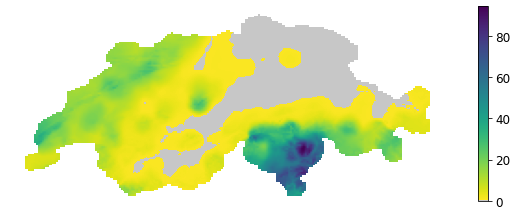

In [16]:
# Plotting an example
plt.figure(figsize=(8, 3))
img = rescale_img(X_train[100, :, :], nan_mask=nan_mask,
                  scaling=X_q95)
plt.imshow(img, cmap=newcmp)
plt.axis('off')
plt.tight_layout()
plt.colorbar()

Text(0.5, 1.0, 'Std of precipitation after scaling')

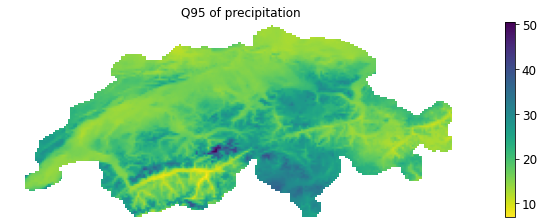

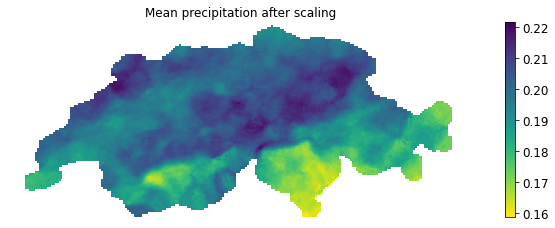

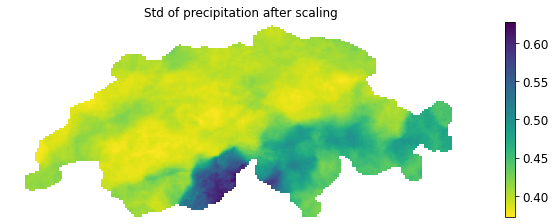

In [17]:
# Plotting caracteristics of the precip data
plt.figure(figsize=(9, 3))
plt.imshow(X_q95)
plt.axis('off')
plt.tight_layout()
plt.set_cmap('viridis_r')
plt.colorbar()
plt.title('Q95 of precipitation')

v_mean = X_train.mean(axis=0)
v_mean[nan_mask] = np.nan
plt.figure(figsize=(9, 3))
plt.imshow(v_mean)
plt.axis('off')
plt.tight_layout()
plt.set_cmap('viridis_r')
plt.colorbar()
plt.title('Mean precipitation after scaling')

v_std = X_train.std(axis=0)
v_std[nan_mask] = np.nan
plt.figure(figsize=(9, 3))
plt.imshow(v_std)
plt.axis('off')
plt.tight_layout()
plt.set_cmap('viridis_r')
plt.colorbar()
plt.title('Std of precipitation after scaling')

# Convolutional Autoencoder

### Define the model

In [18]:
class CAE(tf.keras.Model):
    """Convolutional autoencoder."""

    def __init__(self, data_size, latent_dim=2, architecture=1):
        super(CAE, self).__init__()
        self.data_size = list(data_size)
        self.latent_dim = latent_dim
        self.preflat_shape = 1

        if architecture == 1:
            self.create_v1()
        elif architecture == 2:
            self.create_v2()
        elif architecture == 3:
            self.create_v3()
        else:
            raise('The architecture was not correctly defined')
            self.create_v1()
            
        self.crop_output()
        
        
    def create_v1(self):
        self.encoder = tf.keras.Sequential(
            [
                layers.InputLayer(input_shape=self.data_size),
                layers.Reshape(target_shape = self.data_size+[1]),
                layers.Conv2D(32, 3, strides=(2, 2), padding='same', activation='relu'),
                layers.Conv2D(64, 3, strides=(2, 2), padding='same', activation='relu'),
                layers.Flatten(),
                layers.Dense(self.latent_dim, activation='sigmoid'),
            ]
        )

        self.preflat_shape = self.encoder.layers[-2].input.get_shape().as_list()[1:]
        
        print(self.preflat_shape)

        self.decoder = tf.keras.Sequential(
            [
                layers.InputLayer(input_shape=(self.latent_dim,)),
                layers.Dense(np.prod(self.preflat_shape), activation='relu'),
                layers.Reshape(target_shape=self.preflat_shape),
                layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu'),
                layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu'),
                layers.Conv2DTranspose(1, 3, strides=1, activation='relu', padding='same'),
            ]
        )

        
    def create_v2(self):
        self.encoder = tf.keras.Sequential(
            [
                layers.InputLayer(input_shape=self.data_size),
                layers.Reshape(target_shape = self.data_size+[1]),
                layers.Conv2D(8, 3, padding='same', activation='relu', kernel_initializer='he_normal'),
                layers.Conv2D(8, 3, strides=(2,2), padding='same', activation='relu', kernel_initializer='he_normal'),
                layers.Conv2D(16, 3, strides=(2,2), padding='same', activation='relu', kernel_initializer='he_normal'),
                layers.Conv2D(16, 3, strides=(2,2), padding='same', activation='relu', kernel_initializer='he_normal'),
                layers.Conv2D(32, 3, strides=(2,2), padding='same', activation='relu', kernel_initializer='he_normal'),
                layers.Flatten(),
                layers.Dense(self.latent_dim, activation='sigmoid', kernel_initializer='he_normal')
            ]
        )
        
        self.preflat_shape = self.encoder.layers[-2].input.get_shape().as_list()[1:]

        self.decoder = tf.keras.Sequential(
            [
                layers.InputLayer(input_shape=(self.latent_dim,)),
                layers.Dense(np.prod(self.preflat_shape), activation='relu', kernel_initializer='he_normal'),
                layers.Reshape(target_shape=self.preflat_shape),
                layers.Conv2DTranspose(16, 3, strides=(2,2), padding='same', activation='relu', kernel_initializer='he_normal'),
                layers.Conv2DTranspose(16, 3, strides=(2,2), padding='same', activation='relu', kernel_initializer='he_normal'),
                layers.Conv2DTranspose(16, 3, strides=(2,2), padding='same', activation='relu', kernel_initializer='he_normal'),
                layers.Conv2DTranspose(8, 3, strides=(2,2), padding='same', activation='relu', kernel_initializer='he_normal'),
                layers.Conv2D(1, 3, strides=(1,1), padding='same', activation='relu', kernel_initializer='he_normal')
            ]
        )
        
        
    def create_v3(self):
        self.encoder = tf.keras.Sequential(
            [
                layers.InputLayer(input_shape=self.data_size),
                layers.Reshape(target_shape = self.data_size+[1]),
                layers.Conv2D(8, 3, padding='same', activation='relu', kernel_initializer='he_normal'),
                layers.Conv2D(8, 3, strides=(2,2), padding='same', activation='relu', kernel_initializer='he_normal'),
                layers.Conv2D(16, 3, strides=(2,2), padding='same', activation='relu', kernel_initializer='he_normal'),
                layers.Conv2D(16, 3, strides=(2,2), padding='same', activation='relu', kernel_initializer='he_normal'),
                layers.Conv2D(32, 3, strides=(2,2), padding='same', activation='relu', kernel_initializer='he_normal'),
                layers.Conv2D(32, 3, strides=(2,2), padding='same', activation='relu', kernel_initializer='he_normal'),
                layers.Conv2D(64, 3, strides=(2,2), padding='same', activation='relu', kernel_initializer='he_normal'),
                layers.Flatten(),
                layers.Dense(self.latent_dim, activation='sigmoid', kernel_initializer='he_normal')
            ]
        )
        
        self.preflat_shape = self.encoder.layers[-2].input.get_shape().as_list()[1:]

        self.decoder = tf.keras.Sequential(
            [
                layers.InputLayer(input_shape=(self.latent_dim,)),
                layers.Dense(np.prod(self.preflat_shape), activation='relu', kernel_initializer='he_normal'),
                layers.Reshape(target_shape=self.preflat_shape),
                layers.Conv2DTranspose(32, 3, strides=(2,2), padding='same', activation='relu', kernel_initializer='he_normal'),
                layers.Conv2DTranspose(32, 3, strides=(2,2), padding='same', activation='relu', kernel_initializer='he_normal'),
                layers.Conv2DTranspose(16, 3, strides=(2,2), padding='same', activation='relu', kernel_initializer='he_normal'),
                layers.Conv2DTranspose(16, 3, strides=(2,2), padding='same', activation='relu', kernel_initializer='he_normal'),
                layers.Conv2DTranspose(16, 3, strides=(2,2), padding='same', activation='relu', kernel_initializer='he_normal'),
                layers.Conv2DTranspose(8, 3, strides=(2,2), padding='same', activation='relu', kernel_initializer='he_normal'),
                layers.Conv2D(1, 3, strides=(1,1), padding='same', activation='relu', kernel_initializer='he_normal')
            ]
        )
        
    def crop_output(self):
        
        h, w = self.decoder.layers[-1].output.get_shape().as_list()[1:3]  # reconstructed width and hight
        h_tgt, w_tgt = self.data_size[:2]
        dh = h - h_tgt  # deltas to be cropped away
        dw = w - w_tgt

        # add to decoder cropping layer and final reshaping
        self.decoder.add(layers.Cropping2D(cropping=((dh//2, dh-dh//2), (dw//2, dw-dw//2))))
        self.decoder.add(layers.Reshape(target_shape=self.data_size,))

        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    
    def encode(self, x):
        return self.encoder(x)

    
    def decode(self, z):
        return self.decoder(z)


### Build and train models with a latent dimension of 2

In [19]:
# Clear session and set tf seed
keras.backend.clear_session()
tf.random.set_seed(42)

# Build and train the model with the first architecture
cae_1_lat_2d = CAE(X_train.shape[1:3], latent_dim=2, architecture=1)
cae_1_lat_2d.compile(optimizer='adam', loss='mse')
history = cae_1_lat_2d.fit(X_test, X_test, epochs=25,
                           validation_data=(X_valid, X_valid))

2021-12-15 17:46:05.968447: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-15 17:46:06.817733: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10188 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:08:00.0, compute capability: 6.1


ListWrapper([25, 60, 64])
Epoch 1/25


2021-12-15 17:46:08.887816: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


58/58 [==============================] - 7s 77ms/step - loss: 0.0745 - val_loss: 0.0857
Epoch 2/25
58/58 [==============================] - 3s 55ms/step - loss: 0.0571 - val_loss: 0.0583
Epoch 3/25
58/58 [==============================] - 3s 55ms/step - loss: 0.0475 - val_loss: 0.0537
Epoch 4/25
58/58 [==============================] - 3s 54ms/step - loss: 0.0448 - val_loss: 0.0476
Epoch 5/25
58/58 [==============================] - 3s 55ms/step - loss: 0.0434 - val_loss: 0.0473
Epoch 6/25
58/58 [==============================] - 3s 55ms/step - loss: 0.0417 - val_loss: 0.0453
Epoch 7/25
58/58 [==============================] - 3s 54ms/step - loss: 0.0381 - val_loss: 0.0361
Epoch 8/25
58/58 [==============================] - 3s 55ms/step - loss: 0.0323 - val_loss: 0.0338
Epoch 9/25
58/58 [==============================] - 3s 55ms/step - loss: 0.0310 - val_loss: 0.0335
Epoch 10/25
58/58 [==============================] - 3s 55ms/step - loss: 0.0306 - val_loss: 0.0326
Epoch 11/25
58/58 [=

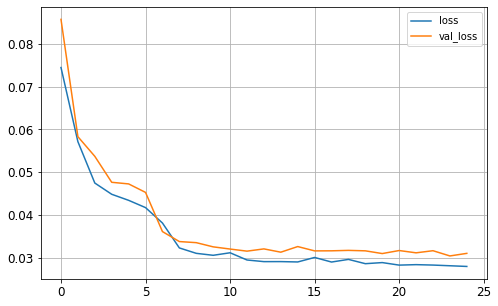

In [20]:
# Plot training evolution
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [21]:
# Clear session and set tf seed
keras.backend.clear_session()
tf.random.set_seed(42)

# Build and train the model with the second architecture
cae_2_lat_2d = CAE(X_train.shape[1:3], latent_dim=2, architecture=2)
cae_2_lat_2d.compile(optimizer='adam', loss='mse')
history = cae_2_lat_2d.fit(X_test, X_test, epochs=25,
                           validation_data=(X_valid, X_valid))

Epoch 1/25
58/58 [==============================] - 4s 55ms/step - loss: 0.0799 - val_loss: 0.0602
Epoch 2/25
58/58 [==============================] - 2s 35ms/step - loss: 0.0482 - val_loss: 0.0472
Epoch 3/25
58/58 [==============================] - 2s 34ms/step - loss: 0.0415 - val_loss: 0.0467
Epoch 4/25
58/58 [==============================] - 2s 34ms/step - loss: 0.0373 - val_loss: 0.0378
Epoch 5/25
58/58 [==============================] - 2s 34ms/step - loss: 0.0343 - val_loss: 0.0360
Epoch 6/25
58/58 [==============================] - 2s 34ms/step - loss: 0.0329 - val_loss: 0.0355
Epoch 7/25
58/58 [==============================] - 2s 33ms/step - loss: 0.0321 - val_loss: 0.0345
Epoch 8/25
58/58 [==============================] - 2s 34ms/step - loss: 0.0317 - val_loss: 0.0343
Epoch 9/25
58/58 [==============================] - 2s 33ms/step - loss: 0.0315 - val_loss: 0.0336
Epoch 10/25
58/58 [==============================] - 2s 34ms/step - loss: 0.0313 - val_loss: 0.0351
Epoch 11/

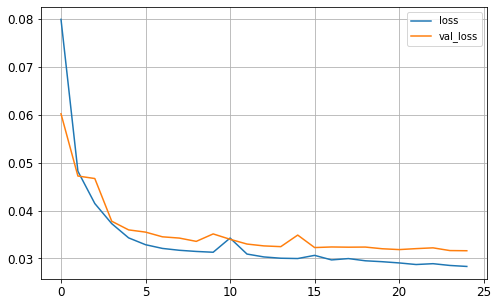

In [22]:
# Plot training evolution
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

### Visualize some reconstructions

In [23]:
# Encode/decode some test data
encoded_imgs_cae_1_lat_2d = cae_1_lat_2d.encoder(X_test).numpy()
decoded_imgs_cae_1_lat_2d = cae_1_lat_2d.decoder(
    encoded_imgs_cae_1_lat_2d[0:300, :]).numpy()
encoded_imgs_cae_2_lat_2d = cae_2_lat_2d.encoder(X_test).numpy()
decoded_imgs_cae_2_lat_2d = cae_2_lat_2d.decoder(
    encoded_imgs_cae_2_lat_2d[0:300, :]).numpy()

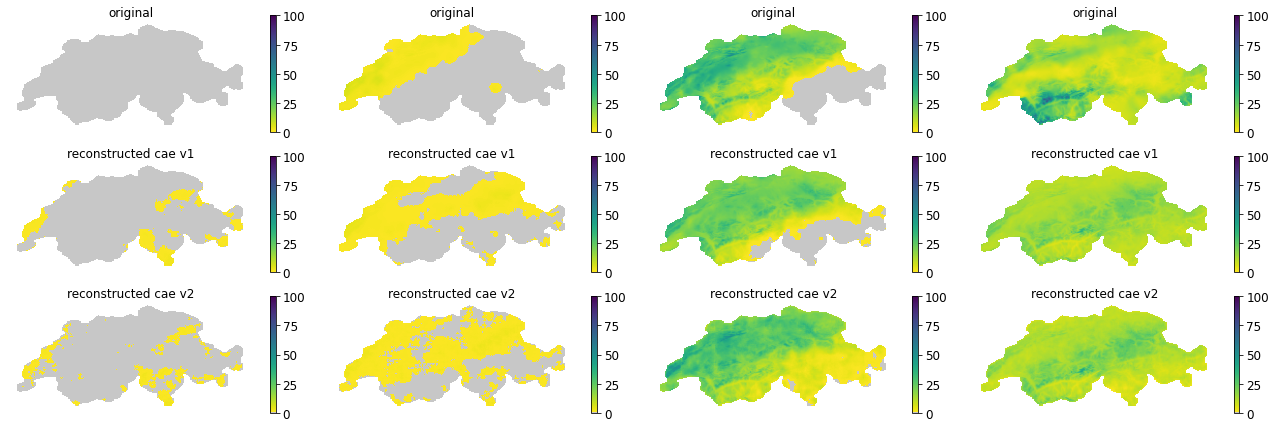

In [24]:
# Plot some samples
plot_sample([235, 0, 7, 10], X_test, X_q95,
            [decoded_imgs_cae_1_lat_2d, decoded_imgs_cae_2_lat_2d])

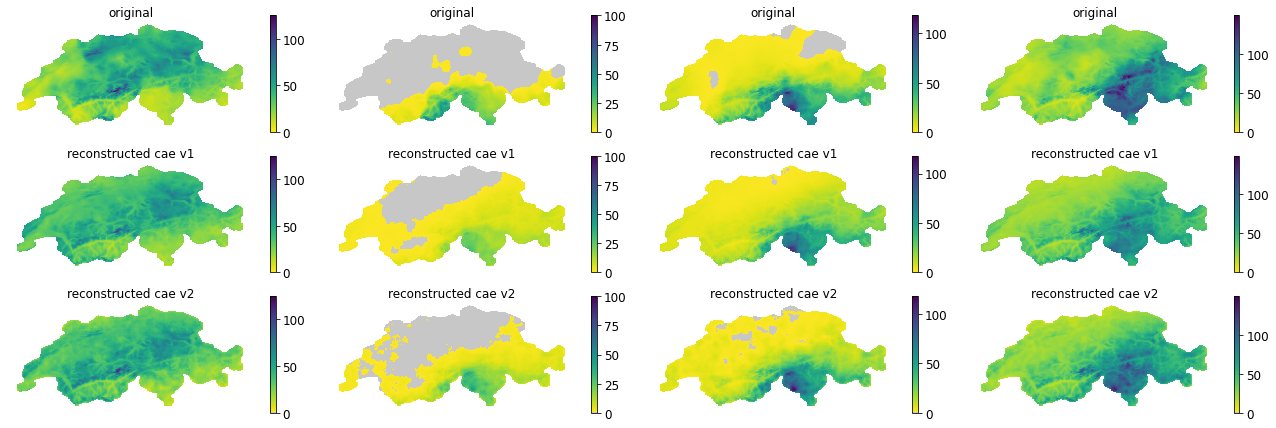

In [25]:
plot_sample([132, 58, 287, 167], X_test, X_q95,
            [decoded_imgs_cae_1_lat_2d, decoded_imgs_cae_2_lat_2d])

(0.0, 1.0)

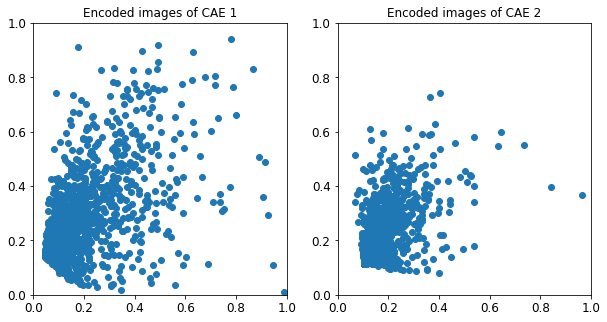

In [26]:
# Plot points from the latent space
f, (ax1, ax2) = plt.subplots(1, 2, figsize=[10, 5])
ax1.scatter(encoded_imgs_cae_1_lat_2d[:, 0],
            encoded_imgs_cae_1_lat_2d[:, 1])
ax1.set_title('Encoded images of CAE 1')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])

ax2.scatter(encoded_imgs_cae_2_lat_2d[:, 0],
            encoded_imgs_cae_2_lat_2d[:, 1])
ax2.set_title('Encoded images of CAE 2')
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])

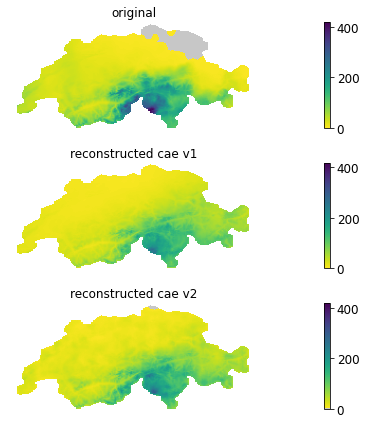

In [27]:
# Plot the max value
idx_max = int(np.argmax(encoded_imgs_cae_2_lat_2d) / 2)
decoded_imgs_cae_1_lat_2d_xtr = cae_1_lat_2d.decoder(
    encoded_imgs_cae_1_lat_2d[idx_max:idx_max+2, :]).numpy()
decoded_imgs_cae_2_lat_2d_xtr = cae_2_lat_2d.decoder(
    encoded_imgs_cae_2_lat_2d[idx_max:idx_max+2, :]).numpy()

plot_sample([0], X_test[idx_max:idx_max+2], X_q95,
            [decoded_imgs_cae_1_lat_2d_xtr, decoded_imgs_cae_2_lat_2d_xtr])

### Visualize sampling of the latent space

In [28]:
n_img_axis = 10
zs = np.meshgrid(np.linspace(0, 1, n_img_axis),
                 np.linspace(0, 1, n_img_axis))
zs = np.stack(zs, axis=-1).reshape((-1, 2))

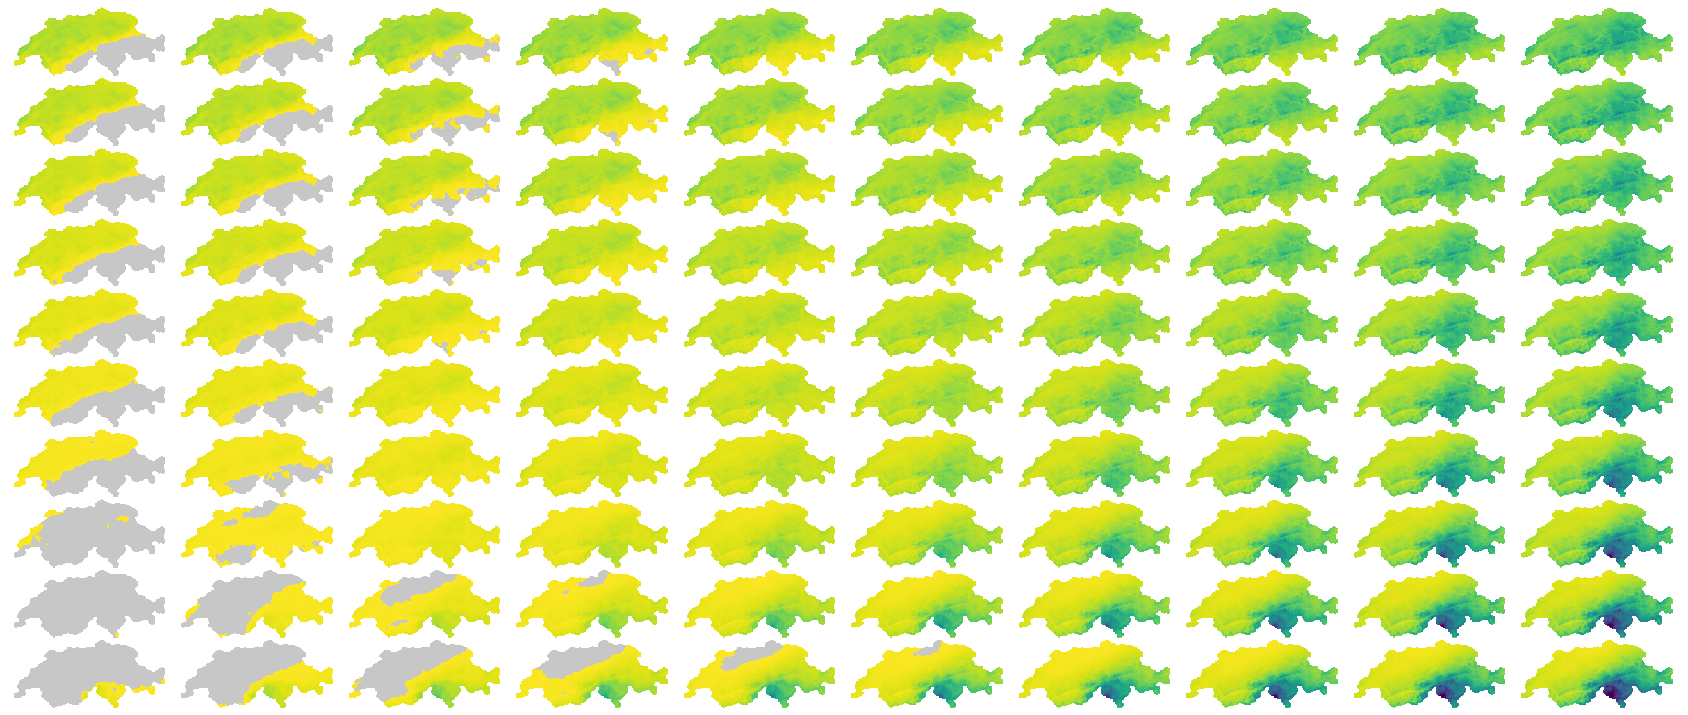

In [29]:
# For the first model
ims = cae_1_lat_2d.decode(zs.reshape((-1, 2))).numpy()
for i_img in range(len(ims)):
    ims[i_img] = rescale_img(ims[i_img], nan_mask=nan_mask, scaling=X_q95)
sh = list(ims.shape)
ims = ims.reshape([n_img_axis, n_img_axis]+sh[1:])

plt.figure(figsize=(30, 30))
plt.imshow(mosaic(ims[::-1]), cmap=newcmp, vmin=0, vmax=200)
plt.axis('off')
plt.show()

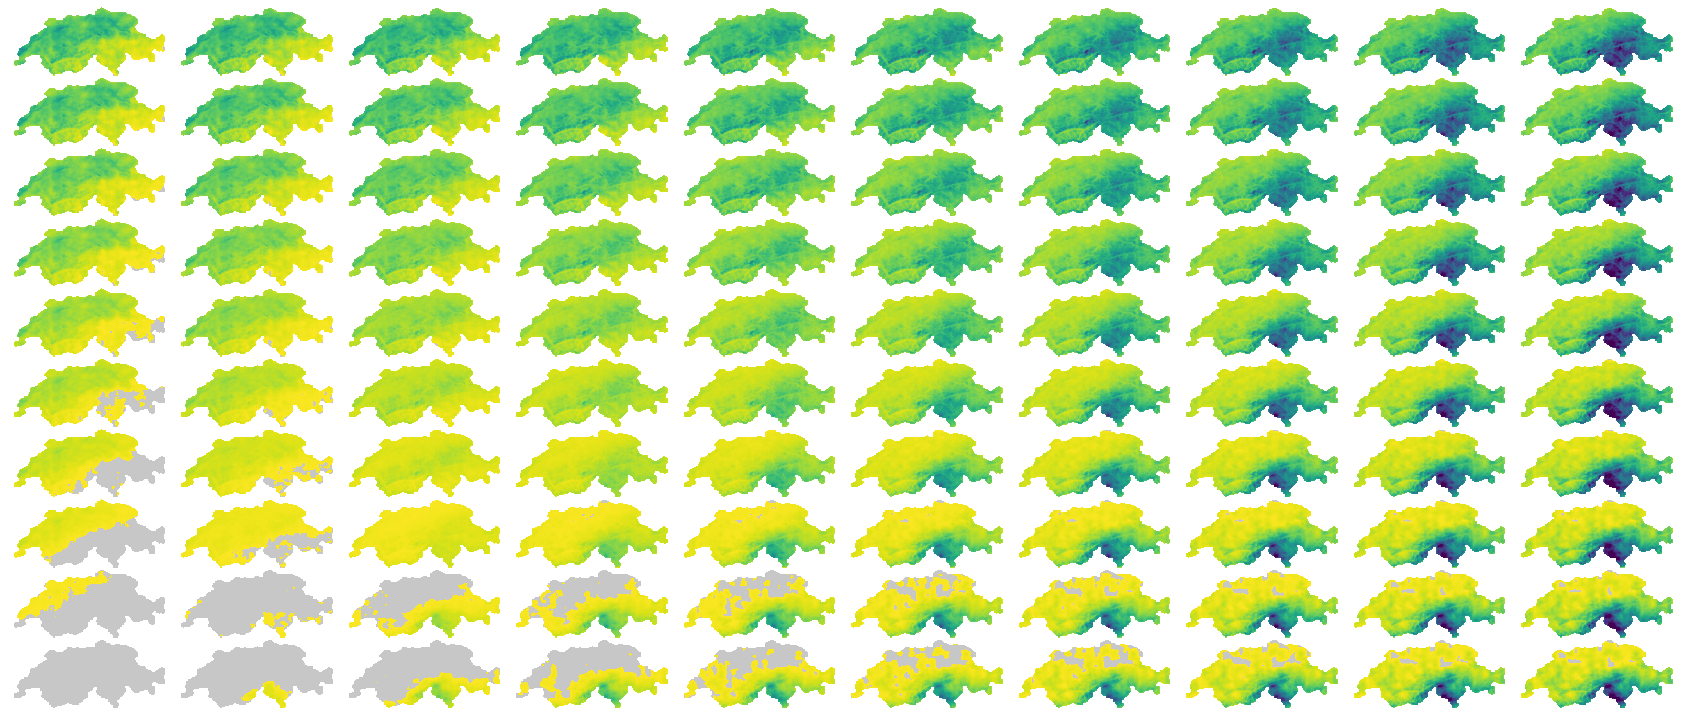

In [30]:
# For the second model
ims = cae_2_lat_2d.decode(zs.reshape((-1, 2))).numpy()
for i_img in range(len(ims)):
    ims[i_img] = rescale_img(ims[i_img], nan_mask=nan_mask, scaling=X_q95)
sh = list(ims.shape)
ims = ims.reshape([n_img_axis, n_img_axis]+sh[1:])

plt.figure(figsize=(30, 30))
plt.imshow(mosaic(ims[::-1]), cmap=newcmp, vmin=0, vmax=200)
plt.axis('off')
plt.show()

### Build and train models with a latent dimension of 64

In [31]:
# Clear session and set tf seed
keras.backend.clear_session()
tf.random.set_seed(42)

# Build and train the model with the first architecture
cae_1_lat_64d = CAE(X_train.shape[1:3], latent_dim=64, architecture=1)
cae_1_lat_64d.compile(optimizer='adam', loss='mse')
history = cae_1_lat_64d.fit(X_test, X_test, epochs=50,
                            validation_data=(X_valid, X_valid))

ListWrapper([25, 60, 64])
Epoch 1/50
58/58 [==============================] - 5s 77ms/step - loss: 0.0637 - val_loss: 0.0482
Epoch 2/50
58/58 [==============================] - 3s 57ms/step - loss: 0.0392 - val_loss: 0.0350
Epoch 3/50
58/58 [==============================] - 3s 57ms/step - loss: 0.0288 - val_loss: 0.0264
Epoch 4/50
58/58 [==============================] - 3s 57ms/step - loss: 0.0219 - val_loss: 0.0216
Epoch 5/50
58/58 [==============================] - 3s 57ms/step - loss: 0.0186 - val_loss: 0.0185
Epoch 6/50
58/58 [==============================] - 3s 57ms/step - loss: 0.0157 - val_loss: 0.0159
Epoch 7/50
58/58 [==============================] - 3s 57ms/step - loss: 0.0135 - val_loss: 0.0146
Epoch 8/50
58/58 [==============================] - 3s 57ms/step - loss: 0.0126 - val_loss: 0.0143
Epoch 9/50
58/58 [==============================] - 3s 57ms/step - loss: 0.0114 - val_loss: 0.0132
Epoch 10/50
58/58 [==============================] - 3s 58ms/step - loss: 0.0105 - 

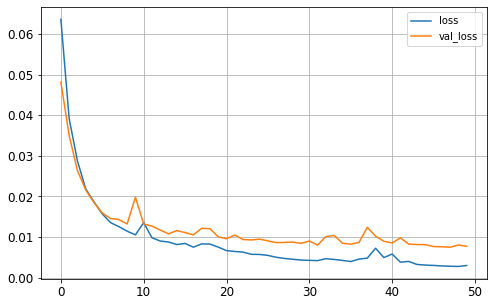

In [32]:
# Plot training evolution
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [33]:
# Clear session and set tf seed
keras.backend.clear_session()
tf.random.set_seed(42)

# Build and train the model with the second architecture
cae_2_lat_64d = CAE(X_train.shape[1:3], latent_dim=64, architecture=2)
cae_2_lat_64d.compile(optimizer='adam', loss='mse')
history = cae_2_lat_64d.fit(X_test, X_test, epochs=50,
                            validation_data=(X_valid, X_valid))

Epoch 1/50
58/58 [==============================] - 4s 54ms/step - loss: 0.0722 - val_loss: 0.0413
Epoch 2/50
58/58 [==============================] - 2s 34ms/step - loss: 0.0296 - val_loss: 0.0250
Epoch 3/50
58/58 [==============================] - 2s 33ms/step - loss: 0.0199 - val_loss: 0.0209
Epoch 4/50
58/58 [==============================] - 2s 36ms/step - loss: 0.0168 - val_loss: 0.0196
Epoch 5/50
58/58 [==============================] - 2s 33ms/step - loss: 0.0151 - val_loss: 0.0170
Epoch 6/50
58/58 [==============================] - 2s 33ms/step - loss: 0.0135 - val_loss: 0.0147
Epoch 7/50
58/58 [==============================] - 2s 33ms/step - loss: 0.0121 - val_loss: 0.0137
Epoch 8/50
58/58 [==============================] - 2s 34ms/step - loss: 0.0111 - val_loss: 0.0130
Epoch 9/50
58/58 [==============================] - 2s 33ms/step - loss: 0.0106 - val_loss: 0.0128
Epoch 10/50
58/58 [==============================] - 2s 33ms/step - loss: 0.0100 - val_loss: 0.0144
Epoch 11/

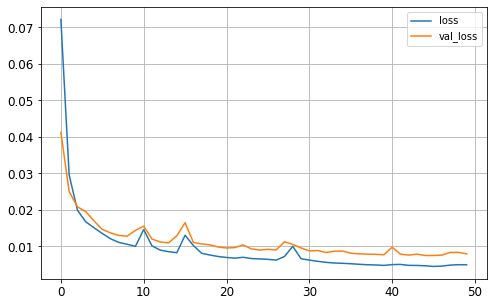

In [34]:
# Plot training evolution
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

### Visualize some reconstructions

In [35]:
# Encode/decode some test data
encoded_imgs_cae_1_lat_64d = cae_1_lat_64d.encoder(X_test).numpy()
decoded_imgs_cae_1_lat_64d = cae_1_lat_64d.decoder(
    encoded_imgs_cae_1_lat_64d[0:300, :]).numpy()
encoded_imgs_cae_2_lat_64d = cae_2_lat_64d.encoder(X_test).numpy()
decoded_imgs_cae_2_lat_64d = cae_2_lat_64d.decoder(
    encoded_imgs_cae_2_lat_64d[0:300, :]).numpy()

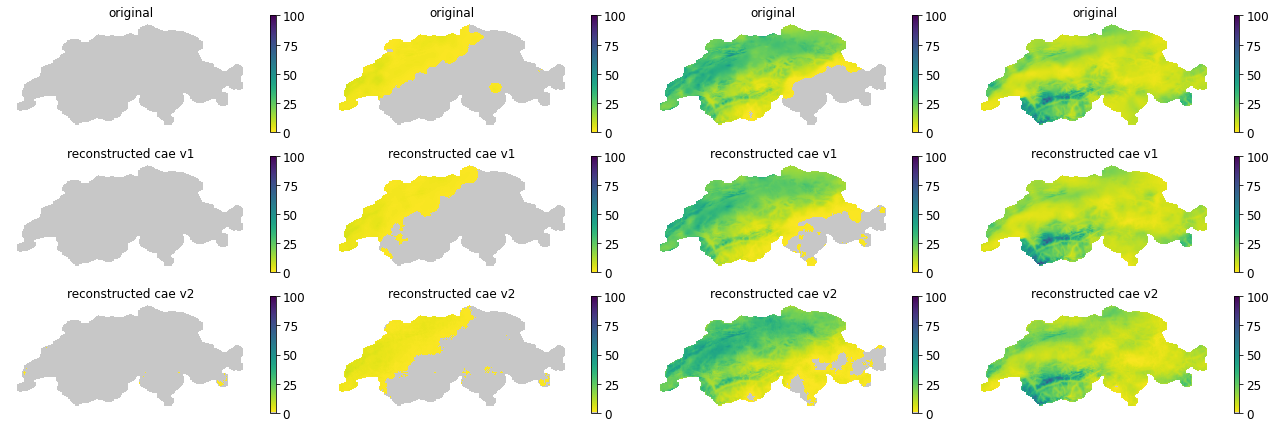

In [36]:
plot_sample([235, 0, 7, 10], X_test, X_q95,
            [decoded_imgs_cae_1_lat_64d, decoded_imgs_cae_2_lat_64d])

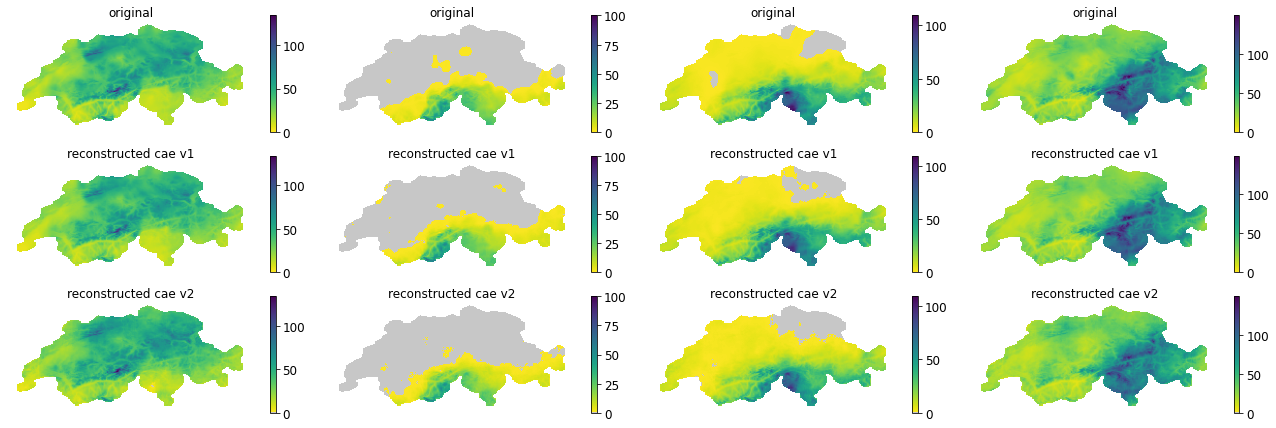

In [37]:
plot_sample([132, 58, 287, 167], X_test, X_q95,
            [decoded_imgs_cae_1_lat_64d, decoded_imgs_cae_2_lat_64d])

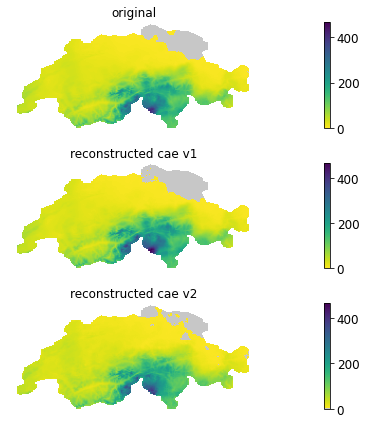

In [38]:
# Plot the max value
decoded_imgs_cae_1_lat_64d_xtr = cae_1_lat_64d.decoder(
    encoded_imgs_cae_1_lat_64d[idx_max:idx_max+2, :]).numpy()
decoded_imgs_cae_2_lat_64d_xtr = cae_2_lat_64d.decoder(
    encoded_imgs_cae_2_lat_64d[idx_max:idx_max+2, :]).numpy()

plot_sample([0], X_test[idx_max:idx_max+2], X_q95,
            [decoded_imgs_cae_1_lat_64d_xtr, decoded_imgs_cae_2_lat_64d_xtr])